Questions for the meeting:

What is out target variable?
Should we just merge all the data?
Should we take all varaibles into account? Which ones we should drop?

Suggested steps

Understand propensity scores 

-Our Frequency is MONTHLY, appropiate datetime

We pick a cutoff point (2019-01-01)

Graphs don't follow any Gauss-Markov assumption, past patterns will continue unhcanged


In [1]:
#Initial Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns 

In [2]:
from sklearn.metrics import accuracy_score

In [3]:
#File Import
client_df = pd.read_csv(r'C:\Users\enriq\OneDrive\Escritorio\BBS\Field Work Lab\3_BANKING_PROPENSITY_SCORING\BANK_CLIENT_clean.csv')
products_df = pd.read_csv(r'C:\Users\enriq\OneDrive\Escritorio\BBS\Field Work Lab\3_BANKING_PROPENSITY_SCORING\BANK_PRODUCTS_clean.csv')
transfer_df = pd.read_csv(r'C:\Users\enriq\OneDrive\Escritorio\BBS\Field Work Lab\3_BANKING_PROPENSITY_SCORING\BANK_TRANSFER_clean.csv')
wealth_df = pd.read_csv(r'C:\Users\enriq\OneDrive\Escritorio\BBS\Field Work Lab\3_BANKING_PROPENSITY_SCORING\BANK_WEALTH_clean.csv')

In [4]:
# Create a dictionary with the data
Labels = {'Client': ['CUSTOMER_ID', 'REGISTRATION_DATE', 'DATE_OF_BIRTH', 'REGION', 'GENDER'],
        'Products': ['CUSTOMER_ID', 'MONTH', 'N_ACCT', 'N_MNG_ACCT', 'N_SAVING_DEPOSIT', 'N_BONDS', 'N_SHARES', 'N_FUNDS', 'N_LIFE_INSURANCE', 'N_MORTGAGE', 'N_FINANCING', 'N_WATER', 'N_LIGHT', 'N_GAS', 'N_TELEFONE', 'N_DEBIT_CARD', 'N_ONLINE_BANKING','N_CREDIT_CARD','N_SICAV_FUNDS','N_PENSION_FUNDS'],
        'Transfer': ['CUSTOMER_ID','MONTH', 'TRANSFER_TYPE_DES','AM_CREDIT', 'AM_DEBIT','NUM_CREDIT','NUM_DEBIT'],
        'Wealth': ['CUSTOMER_ID','MONTH','TOT_DIRECT_DEPOSIT','TOT_ASSETS_UNDER_CUSTODY','TOT_MNG_DEPOSIT','TOT_INVESTMENTS']}

# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(Labels, orient='index')
# Transpose the DataFrame
df = df.transpose()
# Display the resulting table
print(df)

               Client          Products           Transfer  \
0         CUSTOMER_ID       CUSTOMER_ID        CUSTOMER_ID   
1   REGISTRATION_DATE             MONTH              MONTH   
2       DATE_OF_BIRTH            N_ACCT  TRANSFER_TYPE_DES   
3              REGION        N_MNG_ACCT          AM_CREDIT   
4              GENDER  N_SAVING_DEPOSIT           AM_DEBIT   
5                None           N_BONDS         NUM_CREDIT   
6                None          N_SHARES          NUM_DEBIT   
7                None           N_FUNDS               None   
8                None  N_LIFE_INSURANCE               None   
9                None        N_MORTGAGE               None   
10               None       N_FINANCING               None   
11               None           N_WATER               None   
12               None           N_LIGHT               None   
13               None             N_GAS               None   
14               None        N_TELEFONE               None   
15      

In [5]:
final_df = pd.merge(products_df, client_df, on = "CUSTOMER_ID", how = 'left')

final_df.set_index('MONTH',inplace=True) 
pd.to_datetime(final_df.index,format="%Y%m")

DatetimeIndex(['2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01',
               ...
               '2019-03-01', '2019-03-01', '2019-03-01', '2019-03-01',
               '2019-03-01', '2019-03-01', '2019-03-01', '2019-03-01',
               '2019-03-01', '2019-03-01'],
              dtype='datetime64[ns]', name='MONTH', length=180576, freq=None)

In [6]:
final_df["REGION"].astype("category")
final_df["GENDER"].astype("category")

MONTH
201803.0    M
201804.0    M
201805.0    M
201806.0    M
201807.0    M
           ..
201903.0    F
201903.0    M
201903.0    M
201903.0    F
201903.0    F
Name: GENDER, Length: 180576, dtype: category
Categories (2, object): ['F', 'M']

In [7]:
#Convert the Registration Date to DateTime and then to a categorical value
final_df["REGISTRATION_DATE"] = pd.to_datetime(final_df["REGISTRATION_DATE"])
final_df["REG_YEAR"] = final_df["REGISTRATION_DATE"].dt.year 
final_df['REG_CAT'] = pd.cut(final_df["REG_YEAR"], bins=4,labels = ["Long-Term","Loyal","Established","New"])
final_df['REG_CAT'].astype("category")
print(final_df)
#clean BIRTHYEAR,BirthYearBin,REG_YEAR as they are categorized later

         CUSTOMER_ID  N_ACCT  N_MNG_ACCT  N_SAVING_DEPOSIT  N_BONDS  N_SHARES  \
MONTH                                                                           
201803.0  DF00261884       1           1                 0        2         1   
201804.0  DF00261884       1           1                 0        2         1   
201805.0  DF00261884       1           1                 0        1         1   
201806.0  DF00261884       1           1                 0        1         1   
201807.0  DF00261884       1           1                 0        1         1   
...              ...     ...         ...               ...      ...       ...   
201903.0  NN01129128       1           1                 0        0         0   
201903.0  WW01129264       1           1                 0        0         0   
201903.0  HR01129307       1           0                 0        0         0   
201903.0  PA01129365       1           1                 0        0         0   
201903.0  BI01129496       1

In [8]:
#Convert the Date of Birth to DateTime and then to a categorical value
final_df["DATE_OF_BIRTH"] = pd.to_datetime(final_df["DATE_OF_BIRTH"])
final_df["DOB_YEAR"] = final_df["DATE_OF_BIRTH"].dt.year 
final_df['DOB_CAT'] = pd.cut(final_df["DOB_YEAR"], bins=[1946, 1964, 1980, 1996, 2022] ,labels = ["Baby Boomer","Gen X","Millenial","Gen Z"])
final_df['REG_CAT'].astype("category")
print(final_df)

         CUSTOMER_ID  N_ACCT  N_MNG_ACCT  N_SAVING_DEPOSIT  N_BONDS  N_SHARES  \
MONTH                                                                           
201803.0  DF00261884       1           1                 0        2         1   
201804.0  DF00261884       1           1                 0        2         1   
201805.0  DF00261884       1           1                 0        1         1   
201806.0  DF00261884       1           1                 0        1         1   
201807.0  DF00261884       1           1                 0        1         1   
...              ...     ...         ...               ...      ...       ...   
201903.0  NN01129128       1           1                 0        0         0   
201903.0  WW01129264       1           1                 0        0         0   
201903.0  HR01129307       1           0                 0        0         0   
201903.0  PA01129365       1           1                 0        0         0   
201903.0  BI01129496       1

In [9]:
final_df.head()

,CUSTOMER_ID,N_ACCT,N_MNG_ACCT,N_SAVING_DEPOSIT,N_BONDS,N_SHARES,N_FUNDS,N_LIFE_INSURANCE,N_MORTGAGE,N_FINANCING,...,N_SICAV_FUNDS,N_PENSION_FUNDS,REGISTRATION_DATE,DATE_OF_BIRTH,REGION,GENDER,REG_YEAR,REG_CAT,DOB_YEAR,DOB_CAT
MONTH,,,,,,,,,,,,,,,,,,,,,
201803.0,DF00261884,1,1,0,2,1,0,2,0,0,...,8,0,2012-06-08,1987-09-29,EMILIA ROMAGNA,M,2012,Established,1987,Millenial
201804.0,DF00261884,1,1,0,2,1,0,2,0,0,...,8,0,2012-06-08,1987-09-29,EMILIA ROMAGNA,M,2012,Established,1987,Millenial
201805.0,DF00261884,1,1,0,1,1,0,2,0,0,...,8,0,2012-06-08,1987-09-29,EMILIA ROMAGNA,M,2012,Established,1987,Millenial
201806.0,DF00261884,1,1,0,1,1,0,3,0,0,...,8,0,2012-06-08,1987-09-29,EMILIA ROMAGNA,M,2012,Established,1987,Millenial
201807.0,DF00261884,1,1,0,1,1,0,3,0,0,...,8,0,2012-06-08,1987-09-29,EMILIA ROMAGNA,M,2012,Established,1987,Millenial


In [10]:
df_encoded = pd.get_dummies(final_df, columns=['REG_CAT', 'DOB_CAT'], drop_first=True)
print(df_encoded)

         CUSTOMER_ID  N_ACCT  N_MNG_ACCT  N_SAVING_DEPOSIT  N_BONDS  N_SHARES  \
MONTH                                                                           
201803.0  DF00261884       1           1                 0        2         1   
201804.0  DF00261884       1           1                 0        2         1   
201805.0  DF00261884       1           1                 0        1         1   
201806.0  DF00261884       1           1                 0        1         1   
201807.0  DF00261884       1           1                 0        1         1   
...              ...     ...         ...               ...      ...       ...   
201903.0  NN01129128       1           1                 0        0         0   
201903.0  WW01129264       1           1                 0        0         0   
201903.0  HR01129307       1           0                 0        0         0   
201903.0  PA01129365       1           1                 0        0         0   
201903.0  BI01129496       1

Train / Test Split

In [11]:
train = df_encoded.loc[final_df.index < 201901]
test = df_encoded.loc[final_df.index >= 201901]

In [12]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [13]:
features = ['N_ACCT','N_MNG_ACCT','N_SAVING_DEPOSIT','N_BONDS','N_SHARES','N_FUNDS','N_LIFE_INSURANCE','N_MORTGAGE','N_FINANCING',  'REG_CAT_Loyal','REG_CAT_Established',  'REG_CAT_New',  'DOB_CAT_Gen X',  'DOB_CAT_Millenial','DOB_CAT_Gen Z']
target = "N_DEBIT_CARD"

In [14]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [15]:
clf = xgb.XGBClassifier(n_estimators=1000)
clf.fit(X_train, y_train, eval_set =[(X_train, y_train),(X_test, y_test)], verbose= True)

XGBoostError: [12:42:33] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\metric\multiclass_metric.cu:34: Check failed: label_error >= 0 && label_error < static_cast<int32_t>(n_class): MultiClassEvaluation: label must be in [0, num_class), num_class=6 but found 7 in label

<function matplotlib.pyplot.show(close=None, block=None)>

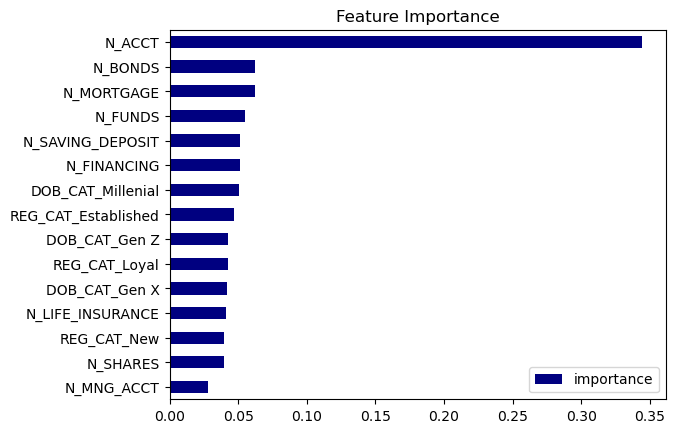

In [ ]:
clf.feature_importances_
fi =pd.DataFrame(data =_xgb_clf.feature_importances_, index =clf.feature_names_in_,columns =["importance"])
fi.sort_values('importance').plot(kind = "barh", title ="Feature Importance", color = "navy")
plt.show

In [ ]:
propensity_scores = clf.predict_proba(X_test)[:, 1]
print(propensity_scores)
X_test['propensity_score'] = propensity_scores


[0.02426899 0.02426899 0.02426899 ... 0.6544192  0.5229308  0.6548285 ]


C:\Users\enriq\AppData\Local\Temp\ipykernel_2060\1011020942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['propensity_score'] = propensity_scores


In [ ]:
test['propensity_score'] = X_test['propensity_score'].values

C:\Users\enriq\AppData\Local\Temp\ipykernel_2060\537865929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['propensity_score'] = X_test['propensity_score'].values


In [ ]:
test.drop("Propensity Score", axis = 1)
test.head()

,CUSTOMER_ID,N_ACCT,N_MNG_ACCT,N_SAVING_DEPOSIT,N_BONDS,N_SHARES,N_FUNDS,N_LIFE_INSURANCE,N_MORTGAGE,N_FINANCING,...,REG_YEAR,DOB_YEAR,REG_CAT_Loyal,REG_CAT_Established,REG_CAT_New,DOB_CAT_Gen X,DOB_CAT_Millenial,DOB_CAT_Gen Z,Propensity Score,propensity_score
MONTH,,,,,,,,,,,,,,,,,,,,,
201901.0,DF00261884,1,1,0,1,2,0,3,0,0,...,2012,1987,0,1,0,0,1,0,2,0.024269
201902.0,DF00261884,1,1,0,1,2,0,3,0,0,...,2012,1987,0,1,0,0,1,0,2,0.024269
201903.0,DF00261884,1,1,0,1,2,0,3,0,0,...,2012,1987,0,1,0,0,1,0,2,0.024269
201901.0,IQ00262656,2,1,0,0,0,0,0,0,0,...,2017,1984,0,0,1,0,1,0,1,0.522099
201902.0,IQ00262656,2,1,0,0,0,0,0,0,0,...,2017,1984,0,0,1,0,1,0,1,0.522099


In [ ]:
test_done = pd.DataFrame({"CUSTOMER_ID":test["CUSTOMER_ID"].values,"propensity_score":test["propensity_score"].values})
test_done_done = test_done.groupby('CUSTOMER_ID')['propensity_score'].mean().reset_index()
test_done_done.head()

,CUSTOMER_ID,propensity_score
0,AA00263211,0.570610
1,AA00309049,0.676667
2,AA00313547,0.001539
3,AA00349160,0.113699
4,AA00355641,0.683615


In [ ]:
propensity_scores = clf.predict_proba(X_train)[:, 1]
print(propensity_scores)
X_train['propensity_score'] = propensity_scores

[2.4556142e-01 2.4556142e-01 1.3020270e-01 ... 5.6865567e-05 6.0499579e-01
 1.6161627e-03]


C:\Users\enriq\AppData\Local\Temp\ipykernel_2060\499586320.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['propensity_score'] = propensity_scores


In [ ]:
train['propensity_score'] = X_train['propensity_score'].values

C:\Users\enriq\AppData\Local\Temp\ipykernel_2060\3395255464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['propensity_score'] = X_train['propensity_score'].values


In [ ]:
train.head()

,CUSTOMER_ID,N_ACCT,N_MNG_ACCT,N_SAVING_DEPOSIT,N_BONDS,N_SHARES,N_FUNDS,N_LIFE_INSURANCE,N_MORTGAGE,N_FINANCING,...,GENDER,REG_YEAR,DOB_YEAR,REG_CAT_Loyal,REG_CAT_Established,REG_CAT_New,DOB_CAT_Gen X,DOB_CAT_Millenial,DOB_CAT_Gen Z,propensity_score
MONTH,,,,,,,,,,,,,,,,,,,,,
201803.0,DF00261884,1,1,0,2,1,0,2,0,0,...,M,2012,1987,0,1,0,0,1,0,0.245561
201804.0,DF00261884,1,1,0,2,1,0,2,0,0,...,M,2012,1987,0,1,0,0,1,0,0.245561
201805.0,DF00261884,1,1,0,1,1,0,2,0,0,...,M,2012,1987,0,1,0,0,1,0,0.130203
201806.0,DF00261884,1,1,0,1,1,0,3,0,0,...,M,2012,1987,0,1,0,0,1,0,0.089935
201807.0,DF00261884,1,1,0,1,1,0,3,0,0,...,M,2012,1987,0,1,0,0,1,0,0.089935


In [ ]:
train_done = pd.DataFrame({"CUSTOMER_ID":train["CUSTOMER_ID"].values,"propensity_score":train["propensity_score"].values})
train_done_done = train_done.groupby('CUSTOMER_ID')['propensity_score'].mean().reset_index()
train_done_done.head()

,CUSTOMER_ID,propensity_score
0,AA00263211,0.624713
1,AA00309049,0.676667
2,AA00313547,0.011197
3,AA00349160,0.075878
4,AA00355641,0.683615


In [ ]:
Client_Propensity_Score =  pd.concat([train_done_done, test_done_done], axis=0, ignore_index=True).sort_values(by ="propensity_score")
Client_Propensity_Score['Strategy'] = pd.cut(Client_Propensity_Score["propensity_score"], bins=[0, .40, .60, .80, .999999999999999999] ,labels = ["Reminder","E-mail","Priority","Highest Priority"])


In [ ]:
Client_Propensity_Score["Strategy"].value_counts()

Priority            13155
Reminder             6718
E-mail               6596
Highest Priority     1766
Name: Strategy, dtype: int64

In [ ]:
Client_Propensity_Score.to_csv('Client_Propensity_Score.csv', index=False)